# Ex 2 - Transfer learning

Olivier D'Ancona & Magali Egger

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score
import tensorflow_datasets as tfds

# ~~~ Imports ~~~
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, 
    Dropout, 
    Flatten, 
    Activation,
    Conv2D, 
    MaxPooling2D, 
    BatchNormalization,
    Input,
    concatenate,
)
from tensorflow.keras import utils
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint



2024-05-05 22:07:23.528037: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 22:07:24.426574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/olivier/anaconda3/envs/tensorflow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the Dataset and visualize it

In [2]:
# ~~~ Download CIFAR10 Dataset ~~~
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()


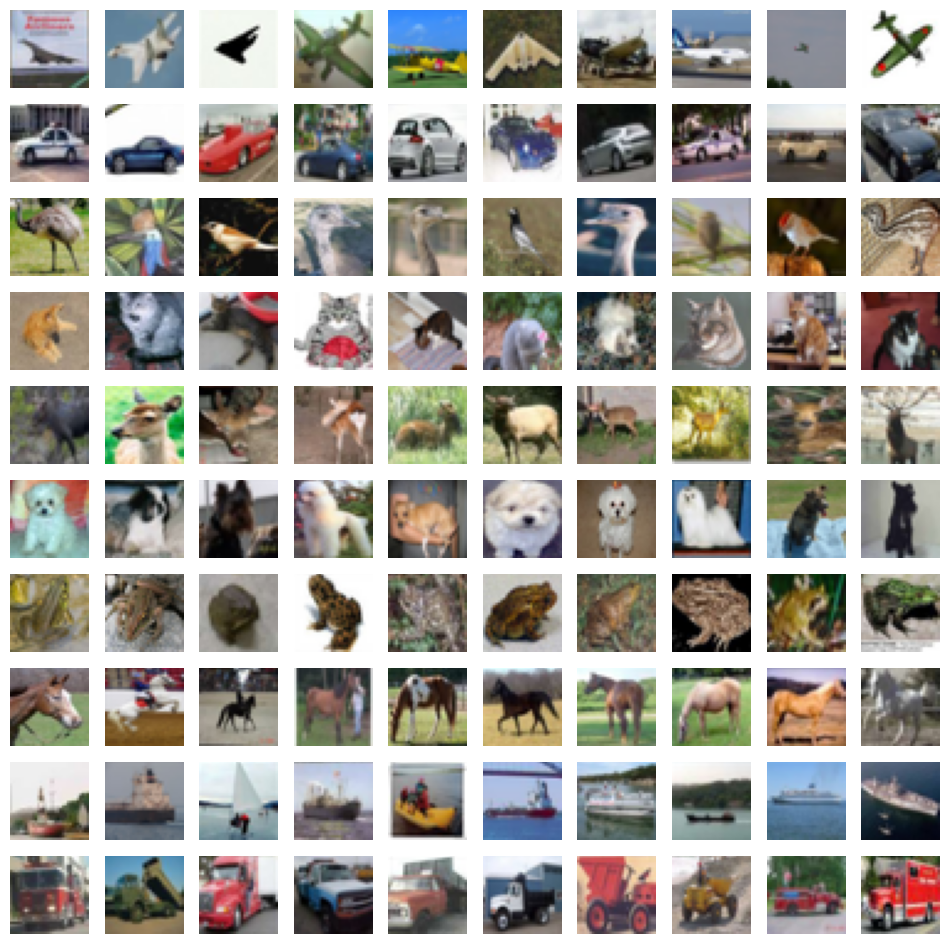

training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 1)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 1)


In [3]:
def show_imgs(X,y):
    plt.figure(1, figsize=(12,12))
    k = 0
    for i in range(0,10):
        for j in range(0,10):
            while y[k] != i: k += 1
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k += 1
    plt.show()

show_imgs(X_test, y_test)
print('training input shape : ', X_train.shape)
print('training output shape: ', y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', y_test.shape)

## Resize and normalize

In [4]:
# Resize the images in the training, validation and test set

# Normalize the images
X_train, X_test = X_train / 255.0, X_test / 255.0

# One hot encode the labels
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

2024-05-05 22:07:28.923572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 22:07:29.059870: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


KeyboardInterrupt: 

## Data-Augmentation

In [ ]:
# Optional define/implements data-augmentation
datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      shear_range=0.2,        
      zoom_range=0.2,        
      fill_mode='nearest')  

train_generator = datagen.flow(X_train, Y_train, batch_size=128)
test_generator = datagen.flow(X_test, Y_test, batch_size=128)

## Training
### Step 1: Only train the head of the network

In [ ]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models. 
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours. 
# A model like mobilenet is more than enough for the exercise.

base_model = keras.applications.EfficientNetV2B0(
    include_top=True,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
)

# Freeze the base_model
base_model.trainable = False

# Create the model structure
inputs = keras.Input(shape=(32, 32, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

2024-05-05 22:04:59.438095: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 22:04:59.460947: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


29403144/29403144 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


ValueError: Input 0 of layer "efficientnetv2-b0" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 32, 32, 3)

In [ ]:
%%time

# Compile the model with your optimizer, your loss and your metrics
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])
    
# Optional: Define and use callbacks
step1_history = model.fit(train_generator, epochs=20, callbacks=ModelCheckpoint(checkpoint_filepath, save_best_only=True), validation_data=test_generator)


NameError: name 'model' is not defined

In [ ]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(step1_history, 'loss')

### Step 2: Fine-Tune the whole model

In [ ]:
%%time


# Unfreeze the pretrained base. 
TODO...


# Compile the model again
TODO...


# Retrain the model
step2_history = model.fit(train_ds, TODO...) # You should us a small learning rate: for example 1e-5 or 1e-6

In [ ]:
plot_history(step2_history, 'loss')

## Test the fine-tuned model

In [ ]:
%%time
# Predict the test set
y_pred = model.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

In [ ]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

In [ ]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")
    
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)